In [1]:
import pandas as pd
import numpy as np
import math 
from datetime import datetime

import matplotlib.pyplot as plt  
import seaborn as sns

In [2]:
# Import the data data
subscriptions = pd.read_csv('subscriptionsdataFINAL.csv') 
visitation_part1 = pd.read_csv('visitationdataPART1.csv') 
visitation_part2 = pd.read_csv('visitationdataPART2.csv')  

In [3]:
# Chane the timestamp
subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions['Join_year'] = pd.DatetimeIndex(subscriptions['Join Date']).year
subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions.dropna()
subscriptions.head()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Join_year
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,2011
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972,2018
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,2018
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2015
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,2015


In [9]:
# Add the peak/off-peak data to the subscriptions data
subscriptions_1 = subscriptions.copy()
visitation_part1_peakvisit = visitation_part1.groupby(['CustomerID', 'peakvisits']).size().unstack(fill_value=0)
visitation_part2_peakvisit = visitation_part2.groupby(['CustomerID', 'peakvisits']).size().unstack(fill_value=0)
visitation_peakvisit = pd.merge(visitation_part1_peakvisit,visitation_part2_peakvisit,on='CustomerID',how='outer').sort_index().replace({np.nan:0})
visitation_peakvisit['False'] = visitation_peakvisit['False_x'] + visitation_peakvisit['False_y']
visitation_peakvisit['True'] = visitation_peakvisit['True_x'] + visitation_peakvisit['True_y']
visitation_peakvisit=visitation_peakvisit.drop(columns=['False_x','True_x','False_y','True_y'])
visitation_peakvisit['Peak_proportion'] = visitation_peakvisit['True']/(visitation_peakvisit['True'] + visitation_peakvisit['False'])
def classify_peak(Peak_proportion):
    if Peak_proportion < 0.35:
        return 'Off_Peak_Customer'
    elif 0.35 <= Peak_proportion < 0.65:
        return 'Average'
    else:
        return 'Peak_Customer'
visitation_peakvisit['Peak_category'] = visitation_peakvisit['Peak_proportion'].apply(lambda x : classify_peak(x))
subscriptions_1 = pd.merge(subscriptions_1,visitation_peakvisit['Peak_category'],on='CustomerID',how='outer')
subscriptions_1

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Join_year,Peak_category
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,2011,Average
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972,2018,Average
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,2018,Peak_Customer
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2015,Average
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,2015,Peak_Customer
...,...,...,...,...,...,...,...,...,...,...
850028,Lewisham,2018-12-01,A,Male,Standard,NaT,850029,1995,2018,Average
850029,Tower Hamlets,2013-10-01,B,Male,Standard,2014-02-01,850030,1987,2013,Average
850030,Redbridge,2018-05-01,C1,Female,Standard,2018-09-01,850031,1985,2018,Peak_Customer
850031,Camden,2017-07-01,B,Female,Standard,2017-09-01,850032,1978,2017,Average


In [10]:
# Monthly
# Calculate the number of member joined, the number of member left, net member, cumulative member
subscriptions_2 = subscriptions_1.copy()
member_joined_data = subscriptions_2.groupby(['Join Date','Peak_category']).size().reset_index(name='Number_of_Member_Joined')
member_joined_data = member_joined_data.rename(columns={'Join Date': "Date"})
member_left_data = subscriptions_2.groupby(['End Date','Peak_category']).size().reset_index(name='Number_of_Member_Left')
member_left_data=member_left_data.rename(columns={'End Date': "Date"})
member_left_data['Date']=member_left_data['Date'] + pd.DateOffset(months=1)
member_data = pd.merge(member_joined_data,member_left_data,on = ['Peak_category','Date'],how='outer').sort_index().replace({np.nan:0})
member_data['Net_Member'] = member_data['Number_of_Member_Joined'] - member_data['Number_of_Member_Left'] 
member_data = pd.DataFrame(member_data.groupby(['Date','Peak_category']).sum())
member_data['Cumulative_Member'] = member_data.groupby(level=-1)['Net_Member'].cumsum()
member_data

Number_of_Member_Joined  Number_of_Member_Left  \
Date       Peak_category                                                       
2009-05-01 Average                              542.0                    0.0   
           Off_Peak_Customer                     66.0                    0.0   
           Peak_Customer                         84.0                    0.0   
2009-06-01 Average                              413.0                   22.0   
           Off_Peak_Customer                     64.0                    5.0   
...                                               ...                    ...   
2018-12-01 Off_Peak_Customer                   1469.0                 1158.0   
           Peak_Customer                       2406.0                 1728.0   
2019-01-01 Average                                0.0                 9562.0   
           Off_Peak_Customer                      0.0                 1137.0   
           Peak_Customer                          0.0                 1769.0   

                              Net_Member  Cumulative_Member  
Date       Peak_category                                     
2009-05-01 Average                 542.0              542.0  
           Off_Peak_Customer        66.0               66.0  
           Peak_Customer            84.0               84.0  
2009-06-01 Average                 391.0              933.0  
           Off_Peak_Customer        59.0              125.0  
...                                  ...                ...  
2018-12-01 Off_Peak_Customer       311.0             6117.0  
           Peak_Customer           678.0             8533.0  
2019-01-01 Average               -9562.0            40600.0  
           Off_Peak_Customer     -1137.0             4980.0  
           Peak_Customer         -1769.0             6764.0  

[351 rows x 4 columns]

In [11]:
# Monthly
# Calculate the revenue
member_data_1 = member_data.copy()
date_while_price_changed = pd.Timestamp('2016-01-01') 
date_min = pd.Timestamp('2009-05-01') 
date_max = pd.Timestamp('2019-01-01') 
dates_before_price_change = pd.date_range(date_min, date_while_price_changed, freq = 'MS')
dates_after_price_change = pd.date_range(date_while_price_changed, date_max, freq = 'MS')

Average_data = pd.DataFrame(member_data_1.xs('Average', level=1, drop_level=False))
Off_Peak_Customer_data = pd.DataFrame(member_data_1.xs('Off_Peak_Customer', level=1, drop_level=False))
Peak_Customer_data = pd.DataFrame(member_data_1.xs('Peak_Customer', level=1, drop_level=False))

Average_data.loc[dates_before_price_change,'Membership_Revenue'] = Average_data.loc[dates_before_price_change,'Cumulative_Member'] * 25.99
Average_data.loc[dates_after_price_change,'Membership_Revenue'] = Average_data.loc[dates_after_price_change,'Cumulative_Member'] * 30.99
Off_Peak_Customer_data.loc[dates_before_price_change,'Membership_Revenue'] = Off_Peak_Customer_data.loc[dates_before_price_change,'Cumulative_Member'] * 20.99
Off_Peak_Customer_data.loc[dates_after_price_change,'Membership_Revenue'] = Off_Peak_Customer_data.loc[dates_after_price_change,'Cumulative_Member'] * 26.99
Peak_Customer_data.loc[dates_before_price_change,'Membership_Revenue'] = Peak_Customer_data.loc[dates_before_price_change,'Cumulative_Member'] * 20.99
Peak_Customer_data.loc[dates_after_price_change,'Membership_Revenue'] = Peak_Customer_data.loc[dates_after_price_change,'Cumulative_Member'] * 26.99

Average_data = Average_data['Membership_Revenue']
Off_Peak_Customer_data = Off_Peak_Customer_data['Membership_Revenue']
Peak_Customer_data = Peak_Customer_data['Membership_Revenue']

Revenue_data = pd.DataFrame(pd.concat([Average_data, Off_Peak_Customer_data,Peak_Customer_data]))

member_data_1 = pd.merge(member_data_1,Revenue_data,on = ['Date','Peak_category'],how='left')
member_data_1['Join_Revenue'] = member_data_1['Number_of_Member_Joined'] * 5
member_data_1['Total_Revenue'] = member_data_1['Membership_Revenue'] +  member_data_1['Join_Revenue']
member_data_1

Number_of_Member_Joined  Number_of_Member_Left  \
Date       Peak_category                                                       
2009-05-01 Average                              542.0                    0.0   
           Off_Peak_Customer                     66.0                    0.0   
           Peak_Customer                         84.0                    0.0   
2009-06-01 Average                              413.0                   22.0   
           Off_Peak_Customer                     64.0                    5.0   
...                                               ...                    ...   
2018-12-01 Off_Peak_Customer                   1469.0                 1158.0   
           Peak_Customer                       2406.0                 1728.0   
2019-01-01 Average                                0.0                 9562.0   
           Off_Peak_Customer                      0.0                 1137.0   
           Peak_Customer                          0.0                 1769.0   

                              Net_Member  Cumulative_Member  \
Date       Peak_category                                      
2009-05-01 Average                 542.0              542.0   
           Off_Peak_Customer        66.0               66.0   
           Peak_Customer            84.0               84.0   
2009-06-01 Average                 391.0              933.0   
           Off_Peak_Customer        59.0              125.0   
...                                  ...                ...   
2018-12-01 Off_Peak_Customer       311.0             6117.0   
           Peak_Customer           678.0             8533.0   
2019-01-01 Average               -9562.0            40600.0   
           Off_Peak_Customer     -1137.0             4980.0   
           Peak_Customer         -1769.0             6764.0   

                              Membership_Revenue  Join_Revenue  Total_Revenue  
Date       Peak_category                                                       
2009-05-01 Average                      14086.58        2710.0       16796.58  
           Off_Peak_Customer             1385.34         330.0        1715.34  
           Peak_Customer                 1763.16         420.0        2183.16  
2009-06-01 Average                      24248.67        2065.0       26313.67  
           Off_Peak_Customer             2623.75         320.0        2943.75  
...                                          ...           ...            ...  
2018-12-01 Off_Peak_Customer           165097.83        7345.0      172442.83  
           Peak_Customer               230305.67       12030.0      242335.67  
2019-01-01 Average                    1258194.00           0.0     1258194.00  
           Off_Peak_Customer           134410.20           0.0      134410.20  
           Peak_Customer               182560.36           0.0      182560.36  

[351 rows x 7 columns]

In [12]:
# Yearly
# The number of members and the total revenue
member_data_yearly=member_data_1.reset_index()
member_data_yearly['Year'] = member_data_yearly.apply(lambda row: row['Date'].year,axis=1)
member_data_yearly=member_data_yearly.groupby(['Year','Peak_category']).sum()
member_data_yearly.head()

Number_of_Member_Joined  Number_of_Member_Left  \
Year Peak_category                                                       
2009 Average                             6938.0                 2085.0   
     Off_Peak_Customer                    808.0                  322.0   
     Peak_Customer                       1239.0                  510.0   
2010 Average                            17515.0                13709.0   
     Off_Peak_Customer                   2147.0                 1727.0   

                        Net_Member  Cumulative_Member  Membership_Revenue  \
Year Peak_category                                                          
2009 Average                4853.0            21469.0           557979.31   
     Off_Peak_Customer       486.0             2293.0            48130.07   
     Peak_Customer           729.0             3323.0            69749.77   
2010 Average                3806.0            83325.0          2165616.75   
     Off_Peak_Customer       420.0             8657.0           181710.43   

                        Join_Revenue  Total_Revenue  
Year Peak_category                                   
2009 Average                 34690.0      592669.31  
     Off_Peak_Customer        4040.0       52170.07  
     Peak_Customer            6195.0       75944.77  
2010 Average                 87575.0     2253191.75  
     Off_Peak_Customer       10735.0      192445.43

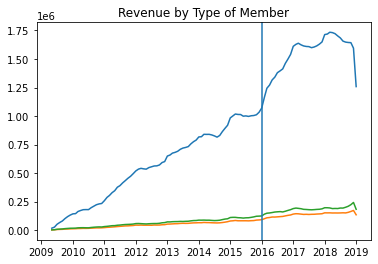

In [13]:
#Plot the chart of monthly revenue
member_data_3=member_data_1.copy()
date_min = pd.Timestamp('2009-05-01') 
date_max = pd.Timestamp('2019-01-01') 
Date = pd.date_range(date_min, date_max, freq = 'MS')

Average_data = pd.DataFrame(member_data_3.xs('Average', level=1, drop_level=False))
Off_Peak_Customer_data = pd.DataFrame(member_data_3.xs('Off_Peak_Customer', level=1, drop_level=False))
Peak_Customer_data = pd.DataFrame(member_data_3.xs('Peak_Customer', level=1, drop_level=False))

Average = Average_data['Total_Revenue']
Off_Peak_Customer = Off_Peak_Customer_data['Total_Revenue']
Peak_Customer = Peak_Customer_data['Total_Revenue']

plt.plot(Date,Average,label='Average')
plt.plot(Date,Off_Peak_Customer,label='Off Peak Customer')
plt.plot(Date,Peak_Customer,label='Peak Customer')

plt.title('Revenue by Type of Member')
plt.axvline(x='2016-01-01')

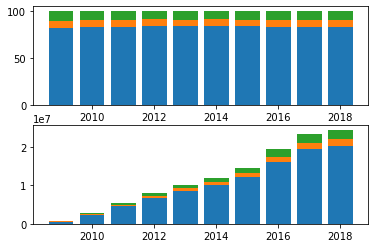

In [14]:
# Plot the Percent stacked barplot and barplot of yearly revenue,seperating the Peak_category
r =  np.arange(2009,2019)

Average_data = pd.DataFrame(member_data_yearly.xs('Average', level=1, drop_level=False)).drop([2019])
Off_Peak_Customer_data = pd.DataFrame(member_data_yearly.xs('Off_Peak_Customer', level=1, drop_level=False)).drop([2019])
Peak_Customer_data = pd.DataFrame(member_data_yearly.xs('Peak_Customer', level=1, drop_level=False)).drop([2019])

Average_Revenue = Average_data['Total_Revenue']
Off_Peak_Customer_Revenue = Off_Peak_Customer_data['Total_Revenue']
Peak_Customer_Revenue = Peak_Customer_data['Total_Revenue']

totals = [i+j+k for i,j,k in zip(Average_Revenue, Off_Peak_Customer_Revenue,Peak_Customer_Revenue)]

Average_revenue_stacked = [i / j * 100 for i,j in zip(Average_Revenue, totals)]
Off_Peak_Customer_revenue_stacked = [i / j * 100 for i,j in zip(Off_Peak_Customer_Revenue, totals)] 
Peak_Customer_revenue_stacked = [i / j * 100 for i,j in zip(Peak_Customer_Revenue, totals)] 

plt.subplot(2, 1, 1)
plt.bar(r,Average_revenue_stacked)
plt.bar(r,Off_Peak_Customer_revenue_stacked, bottom=Average_revenue_stacked)
plt.bar(r,Peak_Customer_revenue_stacked, bottom=[i+j for i,j in zip(Average_revenue_stacked, Off_Peak_Customer_revenue_stacked)])

plt.subplot(2, 1, 2)
plt.bar(r,Average_Revenue)
plt.bar(r,Off_Peak_Customer_Revenue, bottom=Average_Revenue)
plt.bar(r,Peak_Customer_Revenue, bottom=[i+j for i,j in zip(Average_Revenue, Off_Peak_Customer_Revenue)])

plt.show()

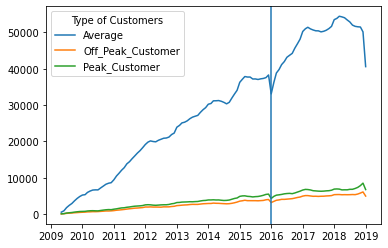

In [15]:
# Plot the cumulative members monthly
Dates = pd.date_range(min(Date), max(Date), freq = 'MS')
Average = member_data_1.xs('Average', level=1, drop_level=False)['Cumulative_Member']
Off_Peak_Customer = member_data_1.xs('Off_Peak_Customer', level=1, drop_level=False)['Cumulative_Member']
Peak_Customer = member_data_1.xs('Peak_Customer', level=1, drop_level=False)['Cumulative_Member']
plt.plot(Dates,Average,label='Average')
plt.plot(Dates,Off_Peak_Customer,label='Off_Peak_Customer')
plt.plot(Dates,Peak_Customer,label='Peak_Customer')
plt.legend(title='Type of Customers')
plt.axvline(x='2016-01-01')

In [16]:
# Breakdown by club and type of customer
number_of_member_breakdown_by_club = subscriptions_1.groupby(['Club','Peak_category','Join_year']).size().reset_index(name='Number_of_Member')
number_of_member_breakdown_by_club

,Club,Peak_category,Join_year,Number_of_Member
0,Barking,Average,2016,3986
1,Barking,Average,2017,4524
2,Barking,Average,2018,4123
3,Barking,Off_Peak_Customer,2016,424
4,Barking,Off_Peak_Customer,2017,547
...,...,...,...,...
553,Westminster,Peak_Customer,2014,522
554,Westminster,Peak_Customer,2015,503
555,Westminster,Peak_Customer,2016,451
556,Westminster,Peak_Customer,2017,452


In [17]:
# Functions which calculate the difference between peak customer and off-peak customer given the year
def calculate_number_of_member_breakdown_by_club(year):
    number_of_member_breakdown_by_club_year=number_of_member_breakdown_by_club.loc[number_of_member_breakdown_by_club['Join_year'] == year]
    sum_number_of_member_breakdown_by_club_year = number_of_member_breakdown_by_club_year.groupby(['Club']).sum(['Number_of_Member']).drop(columns=['Join_year'])
    number_of_member_breakdown_by_club_year=number_of_member_breakdown_by_club_year.merge(sum_number_of_member_breakdown_by_club_year, how='left', on='Club')
    number_of_member_breakdown_by_club_year['Peak_category_percentage'] = number_of_member_breakdown_by_club_year['Number_of_Member_x'] / number_of_member_breakdown_by_club_year['Number_of_Member_y']
    number_of_member_breakdown_by_club_year=number_of_member_breakdown_by_club_year.drop(columns=['Number_of_Member_x','Number_of_Member_y','Join_year'])
    return number_of_member_breakdown_by_club_year

def calculate_difference_peak_offpeak_year(year):
    x=calculate_number_of_member_breakdown_by_club(year)
    df = pd.DataFrame(index = list(x['Club'].unique()))
    for club in list(x['Club'].unique()):
        peak_percentage = list(x.loc[(x['Club'] == club) & (x['Peak_category'] == 'Peak_Customer')]['Peak_category_percentage'])[0]
        offpeak_percentage = list(x.loc[(x['Club'] == club) & (x['Peak_category'] == 'Off_Peak_Customer')]['Peak_category_percentage'])[0]
        Difference = peak_percentage-offpeak_percentage
        df.loc[club,['difference_between_peak_and_offpeak']] = Difference
    return df

In [14]:
# Calculate the difference betweekn peak and off peak for all clubs over 10 years, and filter all the clubs that have opened less than 4 years
index_2=list(np.arange(2009,2019))
index_1=list(number_of_member_breakdown_by_club['Club'].unique())
iterables = [index_1,index_2]
index=pd.MultiIndex.from_product(iterables, names=["Club", "Year"])
zeros_list = np.zeros(len(index_2)*len(index_1))
s = pd.DataFrame(data = zeros_list,index=index,columns=['difference_between_peak_and_offpeak'])
for year in index_2:
     df = calculate_difference_peak_offpeak_year(year)
     for club in list(df.index):
        s.loc[(club, year)]['difference_between_peak_and_offpeak'] = df.loc[club]['difference_between_peak_and_offpeak']  
difference_between_peak_and_offpeak = s[s.difference_between_peak_and_offpeak != 0]   

for club in list(difference_between_peak_and_offpeak.index.get_level_values(0).unique()):
    number_of_row = difference_between_peak_and_offpeak.loc[club].shape[0]
    if number_of_row <4:
        difference_between_peak_and_offpeak = difference_between_peak_and_offpeak.drop(club) 
difference_between_peak_and_offpeak.head(8)

difference_between_peak_and_offpeak
Club   Year                                     
Barnet 2011                             0.007311
       2012                             0.010499
       2013                             0.008633
       2014                             0.013087
       2015                             0.007184
       2016                             0.011745
       2017                             0.006720
       2018                             0.015520

In [15]:
# Find the percentage change between peak and offpeak for all clubs
club_list = list(difference_between_peak_and_offpeak.index.get_level_values(0).unique())
for club in club_list:
    df = difference_between_peak_and_offpeak.loc[club]
    years = sorted(list(df.index.get_level_values(0)[-3:]), reverse=True)
    for year in years:
        this_year = year
        last_year = year-1
        this_year_diff = df.loc[this_year]['difference_between_peak_and_offpeak'] 
        last_year_diff = df.loc[last_year]['difference_between_peak_and_offpeak']
        growth_rate = (this_year_diff-last_year_diff) / last_year_diff
        difference_between_peak_and_offpeak.loc[(club,this_year)]['difference_between_peak_and_offpeak'] = growth_rate
    years = set(sorted(list(df.index.get_level_values(0)[-5:]), reverse=True))
    years_all = set(sorted(list(df.index.get_level_values(0)), reverse=True))
    years_delete = list(set(years_all)-set(years))
    for year in years_delete:
        difference_between_peak_and_offpeak=difference_between_peak_and_offpeak.drop([(club,year)])
        
difference_between_peak_and_offpeak.head(8)

difference_between_peak_and_offpeak
Club   Year                                     
Barnet 2014                             0.013087
       2015                             0.007184
       2016                             0.634968
       2017                            -0.427828
       2018                             1.309412
Bexley 2015                             0.016228
       2016                            -0.189020
       2017                             0.060401

In [16]:
club_list = list(difference_between_peak_and_offpeak.index.get_level_values(0).unique())
for club in club_list:
    df = difference_between_peak_and_offpeak.loc[club]
    if (df['difference_between_peak_and_offpeak'] < 0).all():
        print(club,'Customer are coming to peak time')
    if (df['difference_between_peak_and_offpeak'] > 0).all():
        print(club,'Customer are coming to offpeak time')

Greenwich Customer are coming to offpeak time
Southwark Customer are coming to offpeak time


In [19]:
difference_between_peak_and_offpeak.loc['Southwark']

,difference_between_peak_and_offpeak
Year,
2014,0.005177
2015,0.006063
2016,0.168776
2017,0.099066
2018,0.763049
